# Ubiquitin related figures

This notebook allows to recreate all figures in the manuscript related to Ubiquitin from the provided experimental and calculated relaxation rates.

In [1]:
import ABSURDer as absurder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Patch
from matplotlib.lines import Line2D
import pickle
import scipy.stats as scs
import pandas as pd
import seaborn as sns

In [2]:
def load( inp ):
    pin = open( inp, 'rb' )
    return pickle.load( pin )

In [3]:
def _chi2_nomderr( rex, eex, rmd, r, w):

    rrw = np.dot( rmd, w[:,np.newaxis] )[:,:,0] #removes last, useless axis
    if r == -1:
        er2 = eex**2
        return np.sum( (rex - rrw)**2 / er2 )
    else:
        er2 = eex[r]**2
        return np.sum( (rex[r] - rrw[r])**2 / er2 )
       
def chi2r_nomderr(rex, eex, rmd, r, w='initw'):

    if w=='initw':
        w = np.array([ 1/rmd.shape[-1] for i in range(rmd.shape[-1])])
        
    if r == -1:
        x2 = _chi2_nomderr( rex, eex, rmd, r, w )
        return x2 / ( rex.shape[1] * rex.shape[0] )
    else:
        x2 = _chi2_nomderr( rex, eex, rmd, r, w )
        return x2 / rex.shape[1]              

In [4]:
def calc_RMSE_ensemble(exp,calc,sample_weights):
    calc_avg = np.sum(calc*sample_weights[:,np.newaxis],axis=0)
    diff = calc_avg-exp
    return  np.sqrt(np.average(diff**2))

In [5]:
def get_corr(rex, rmd, r):
    if r == -1:
        return np.corrcoef(rex.flatten(), np.average(rmd, axis=-1).flatten())[0,1]
    else:
        return np.corrcoef(rex[r,:], np.average(rmd, axis=-1)[r,:])[0,1]

In [6]:
def load_data(indir, reps=[1,2,3,4,5,6,7,8,9,10]):
    
    thetas = load(f'{indir}/training/thetas_{reps[0]}.pkl')
    chis_train, phis_train = [], []
    chis_test, phis_test  = [], []

    for rep in reps:
        # print(rep)
        chis_train.append(load(f'{indir}/training/chis_{rep}.pkl')), phis_train.append(load(f'{indir}/training/phis_{rep}.pkl'))
        chis_test.append(load(f'{indir}/test/chis_{rep}.pkl')), phis_test.append(load(f'{indir}/test/phis_{rep}.pkl'))

    data_dict = { 'thetas':thetas, 'chis_train':np.array(chis_train), 'phis_train':np.array(phis_train), 'chis_test':np.array(chis_test), 'phis_test':np.array(phis_test) }
    
    return data_dict

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [8]:
# rate_colors = ['#2a9d8f', '#3FA43E', '#e9c46a', '#f4a261', '#e76f51']
rate_colors = [ '#ffc857', '#084c61', '#db3a34', '#177e89', '#2c6e49', '#323031']

labels     = [ r'$R(D_z)$', r'$R(D_y)$', r'$R(3D_z^2-2)$', r'$R(D_y^2)$', r'$R(D_yD_z+D_zD_y)$' ]
l_hms = 'HMS'
l_cgcorr = r'C$^{\gamma}_{\rm corr.}$'

In [9]:
mlist = '../data/exp/ubiquitin/nmr_methyls.pkl'
rex   = '../data/exp/ubiquitin/nmr_r1r2r3r4r5_rates_liao.npy'
eex   = '../data/exp/ubiquitin/nmr_r1r2r3r4r5_errors_liao.npy'

In [10]:
nmr_methyls = load(mlist)
nmr_rates   = np.load(rex)
nmr_errors  = np.load(eex)

In [11]:
cgcorr = [i for i,ii in enumerate(nmr_methyls) if 'G' in ii]
no_cgcorr = [i for i,ii in enumerate(nmr_methyls) if 'G' not in ii]

In [12]:
rmd_cgcorr  = load('../data/calc/ubiquitin/deltak_CgCorr/rmd.pkl')
ravg_cgcorr = np.average(rmd_cgcorr, axis=-1)

rmd_hms  = load('../data/calc/ubiquitin/deltak_HMS/rmd.pkl')
ravg_hms = np.average(rmd_hms, axis=-1)

# Fig. 3A-E

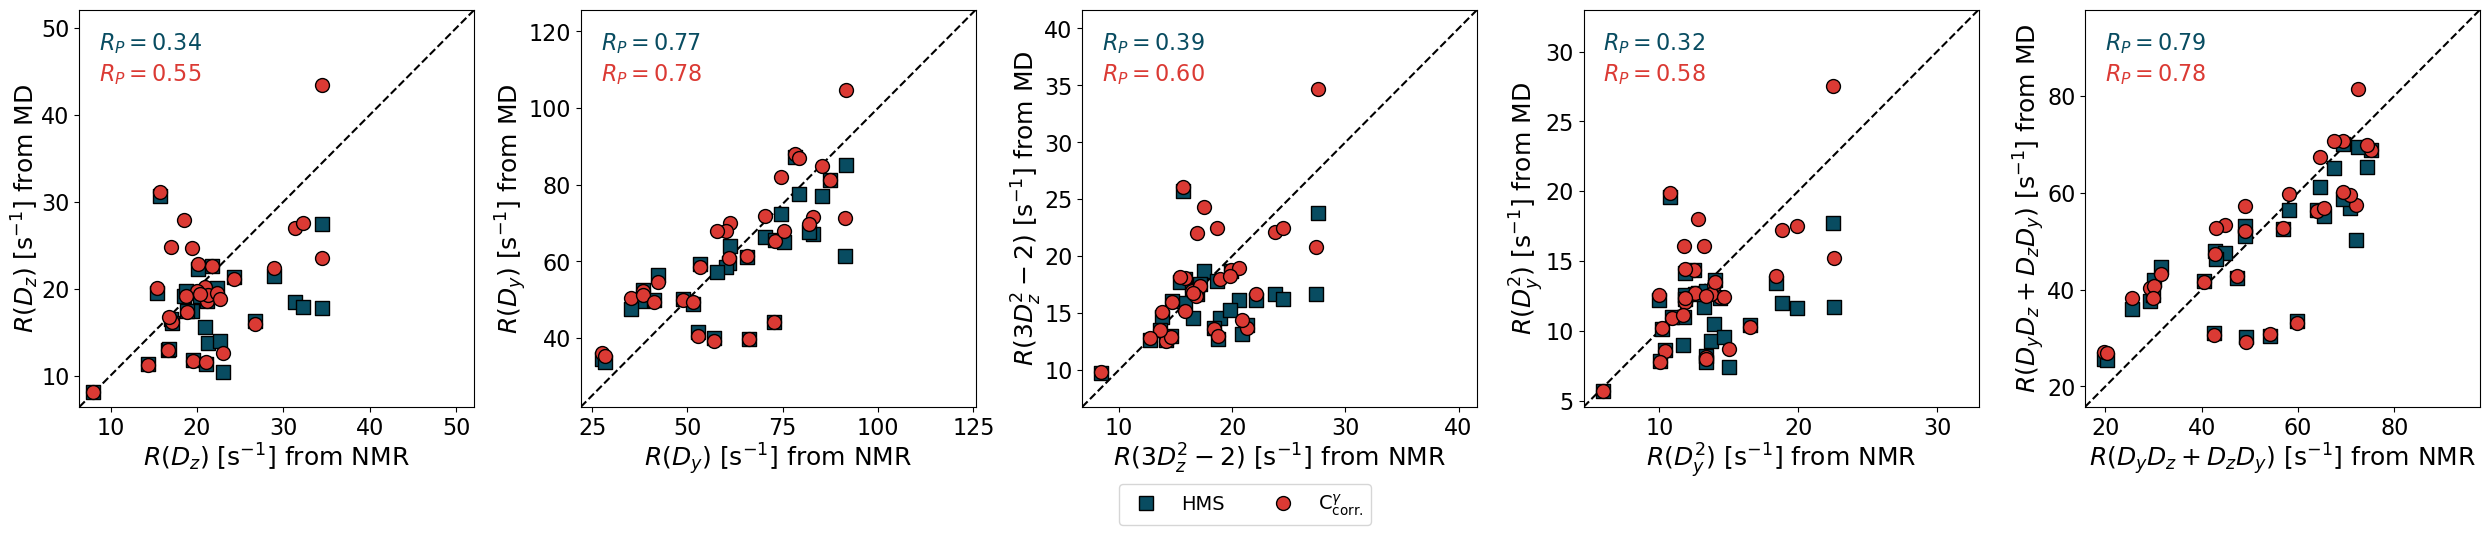

In [13]:
fig = plt.figure(figsize=[25,5])
for r in range(nmr_rates.shape[0]):
    rp = []
    rp.append(np.corrcoef(nmr_rates[r,:], ravg_hms[r,:])[0,1])
    rp.append(np.corrcoef(nmr_rates[r,:], ravg_cgcorr[r,:])[0,1])
    
    ax = plt.subplot(1,5,r+1)
    plt.scatter(nmr_rates[r,:], ravg_hms[r,:], marker='s', color=rate_colors[1], s=90, edgecolor='k')
    plt.scatter(nmr_rates[r,:], ravg_cgcorr[r,:], marker='o', color=rate_colors[2], s=100, edgecolor='k')
    xymin = np.min([nmr_rates[r,:], ravg_hms[r,:]])*0.8
    xymax = np.max([nmr_rates[r,:], ravg_cgcorr[r,:]])*1.2
    plt.plot([xymin,xymax], [xymin,xymax], ls='--', c='k', zorder=-1)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.xlabel(f'{labels[r]} [s$^{{-1}}$] from NMR', fontsize=18, labelpad=1)
    plt.ylabel(f'{labels[r]} [s$^{{-1}}$] from MD', fontsize=18, labelpad=0.001)
    
    plt.text(0.05, 0.9, f'$R_P={rp[0]:.2f}$', fontsize=16, weight=1000, transform=ax.transAxes, color=rate_colors[1])
    plt.text(0.05, 0.82, f'$R_P={rp[1]:.2f}$', fontsize=16, weight=1000, transform=ax.transAxes, color=rate_colors[2])

    
    custom_handles = [Line2D([0], [0], marker='s', ls='', color=rate_colors[1], markeredgecolor='k', markersize=10, label=l_hms),
                      Line2D([0], [0], marker='o', ls='', color=rate_colors[2], markeredgecolor='k', markersize=10, label=l_cgcorr)]
lgd = fig.legend(handles=custom_handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.08))

fig.tight_layout()
fig.savefig('../plots/ubiquitin/fig3_a_b_c_d_e.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.show()

# Fig. 3F

In [14]:
methyl_types = sorted(list(set(i.split('-')[-1] for i in nmr_methyls)))
tmp_labels = [r'All']+labels

chi2s_cgcorr_nomderr = []
chi2s_hms_nomderr   = []
for r in [-1,0,1,2,3,4]:
    tmp_chi2s_cgcorr_nomderr = []
    tmp_chi2s_hms_nomderr   = []
    for mt in [cgcorr, no_cgcorr]:
        idxs =  mt
        tmp_chi2s_cgcorr_nomderr.append( chi2r_nomderr(nmr_rates[:,idxs], nmr_errors[:,idxs], rmd_cgcorr[:,idxs,:], r) )
        tmp_chi2s_hms_nomderr.append( chi2r_nomderr(nmr_rates[:,idxs], nmr_errors[:,idxs], rmd_hms[:,idxs,:], r) )

    chi2s_cgcorr_nomderr.append(tmp_chi2s_cgcorr_nomderr)
    chi2s_hms_nomderr.append(tmp_chi2s_hms_nomderr)  
    
chi2s_cgcorr_nomderr, chi2s_hms_nomderr = np.array(chi2s_cgcorr_nomderr), np.array(chi2s_hms_nomderr)

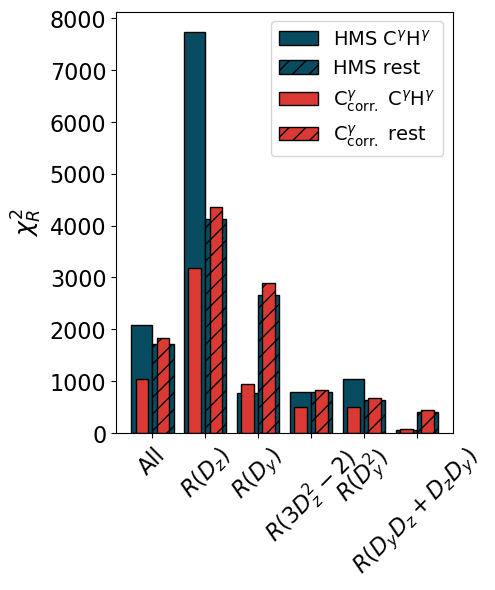

In [15]:

width = 0.4
x = np.arange(len(tmp_labels))

fig,ax  = plt.subplots(figsize=[5,6])
rects1 = ax.bar(x-width/2, chi2s_hms_nomderr[:,0], width, color=rate_colors[1], edgecolor='k', label=r'HMS C$^{\gamma}$H$^{\gamma}$')
rects2 = ax.bar(x+width/2, chi2s_hms_nomderr[:,1], width, color=rate_colors[1], hatch='//', edgecolor='k', label=r'HMS rest')
rects4 = ax.bar(x-width/2, chi2s_cgcorr_nomderr[:,0], width*0.6, color=rate_colors[2], edgecolor='k', label=r'C$^{\gamma}_{\rm corr.}$ C$^{\gamma}$H$^{\gamma}$')    
rects3 = ax.bar(x+width/2, chi2s_cgcorr_nomderr[:,1], width*0.6, color=rate_colors[2], hatch='//', edgecolor='k', label=r'C$^{\gamma}_{\rm corr.}$ rest')

plt.ylabel(r'$\chi^2_R$')
plt.xticks([0,1,2,3,4,5], tmp_labels, rotation=45)
plt.legend()

fig.tight_layout()
fig.savefig('../plots/ubiquitin/fig3_f.pdf', bbox_inches='tight')
fig.show()

# Fig. 3G-H

In [16]:
# for idx,methyl in enumerate(nmr_methyls): # for all methyls
for methyl in ['ILE44-CG2HG2', 'VAL5-CG2HG2']:
    idx = nmr_methyls.index(methyl)
    if 'G' in methyl: # filter only Cg
        fig = plt.figure(figsize=[13,3])
        for r in range( rmd_hms.shape[0] ):
            x      = np.linspace( rmd_hms[r, idx, :].min(), rmd_hms[r, idx, :].max(), num=100 )
            kde_hms = scs.gaussian_kde( rmd_hms[r, idx, :], bw_method='silverman' )
            kde_hms.set_bandwidth( kde_hms.scotts_factor()/1.5 )
            kde_hms = kde_hms.evaluate( x )

            x2      = np.linspace( rmd_cgcorr[r, idx, :].min(), rmd_cgcorr[r, idx, :].max(), num=100 )
            kde_cgcorr = scs.gaussian_kde( rmd_cgcorr[r, idx, :], bw_method='silverman' )
            kde_cgcorr.set_bandwidth( kde_cgcorr.scotts_factor()/1.5 )
            kde_cgcorr = kde_cgcorr.evaluate( x2 )

            my = max([max(kde_hms), max(kde_cgcorr)])
            my += 0.05 * my

            plt.subplot(1, rmd_hms.shape[0], r+1)

            plt.plot( x, kde_hms, lw=3, color=rate_colors[1], zorder=-10 )
            plt.fill_between( x, kde_hms, color=rate_colors[1], alpha=0.3, label='MD hms. ff' )
            plt.vlines( ravg_hms[r, idx], 0, my, color=rate_colors[1], lw=4, linestyle=':', zorder=10, label='Avg. MD hms. ff' )

            plt.plot( x2, kde_cgcorr, lw=3, color=rate_colors[2], zorder=-10)
            plt.fill_between( x2, kde_cgcorr, color=rate_colors[2], alpha=0.3, label='MD optim. ff' )
            plt.vlines( ravg_cgcorr[r, idx], 0, my, color=rate_colors[2], lw=4, linestyle='--', zorder=5, label = 'Avg. MD optim. ff' )

            plt.vlines( nmr_rates[r, idx], 0, my, lw=3, zorder=1, label='NMR', color='k')
            plt.axvspan( nmr_rates[r, idx]-nmr_errors[r, idx], nmr_rates[r, idx]+nmr_errors[r, idx], 0.05, 0.96, color='k', alpha=0.4, zorder=0 )

            label = labels[r] + r' [s$^{-1}$]'
            plt.xlabel(label)
            if r == 0:
                plt.ylabel('p(R)')

            plt.suptitle(methyl, fontsize=18)
    
        plt.tight_layout()#rect=[0, 0, 1, 1.03], w_pad=0.01)
        plt.savefig(f'../plots/ubiquitin/fig3_g_h_{methyl}.pdf')
        plt.show()
    else:
        continue


NameError: name 'kde_cgcorr' is not defined

<Figure size 1300x300 with 0 Axes>

In [ ]:
# for idx,methyl in enumerate(nmr_methyls): # for all methyls
for methyl in ['ILE44-CG2HG2', 'VAL5-CG2HG2']:
    idx = nmr_methyls.index(methyl)
    if 'G' in methyl: # filter only Cg
        fig = plt.figure(figsize=[21,3])
        for r in range( rmd_hms.shape[0] ):
            x      = np.linspace( rmd_hms[r, idx, :].min(), rmd_hms[r, idx, :].max(), num=100 )
            kde_hms = scs.gaussian_kde( rmd_hms[r, idx, :], bw_method='silverman' )
            kde_hms.set_bandwidth( kde_hms.scotts_factor()/1.5 )
            kde_hms = kde_hms.evaluate( x )

            x2      = np.linspace( rmd_cgcorr[r, idx, :].min(), rmd_cgcorr[r, idx, :].max(), num=100 )
            kde_cgcorr = scs.gaussian_kde( rmd_cgcorr[r, idx, :], bw_method='silverman' )
            kde_cgcorr.set_bandwidth( kde_cgcorr.scotts_factor()/1.5 )
            kde_cgcorr = kde_cgcorr.evaluate( x2 )

            my = max([max(kde_hms), max(kde_cgcorr)])
            my += 0.05 * my

            plt.subplot(1, rmd_hms.shape[0], r+1)

            plt.plot( x, kde_hms, lw=3, color=rate_colors[1], zorder=-10 )
            plt.fill_between( x, kde_hms, color=rate_colors[1], alpha=0.3, label='MD hms. ff' )
            plt.vlines( ravg_hms[r, idx], 0, my, color=rate_colors[1], lw=4, linestyle=':', zorder=10, label='Avg. MD hms. ff' )

            plt.plot( x2, kde_cgcorr, lw=3, color=rate_colors[2], zorder=-10)
            plt.fill_between( x2, kde_cgcorr, color=rate_colors[2], alpha=0.3, label='MD optim. ff' )
            plt.vlines( ravg_cgcorr[r, idx], 0, my, color=rate_colors[2], lw=4, linestyle='--', zorder=5, label = 'Avg. MD optim. ff' )

            plt.vlines( nmr_rates[r, idx], 0, my, lw=3, zorder=1, label='NMR', color='k')
            plt.axvspan( nmr_rates[r, idx]-nmr_errors[r, idx], nmr_rates[r, idx]+nmr_errors[r, idx], 0.05, 0.96, color='k', alpha=0.4, zorder=0 )

            label = labels[r] + r' [s$^{-1}$]'
            plt.xlabel(label)
            if r == 0:
                plt.ylabel('p(R)')

            plt.suptitle(methyl, fontsize=18)
        else:
            continue

        plt.tight_layout(rect=[0, 0, 1, 1.03], w_pad=0.0001)
        plt.savefig(f'../plots/ubiquitin/fig3_g_h_{methyl}.pdf')
        plt.show()

# Fig. 3I

In [ ]:
rmd   = '../data/calc/ubiquitin/deltak_CgCorr/rmd.pkl'
tmp_star_cgcorr   = absurder.ABSURDer(rex, rmd, eex, methyl_list=mlist, verbose=True, ignore_last=False, out='../data/calc/ubiquitin/deltak_CgCorr/reweighting', thetas=np.array([2681]))
tmp_star_cgcorr.load_results('../data/calc/ubiquitin/deltak_CgCorr/reweighting/results_theta_2681.pkl')

rmd   = '../data/calc/ubiquitin/deltak_HMS/rmd.pkl'
tmp_star_hms   = absurder.ABSURDer(rex, rmd, eex, methyl_list=mlist, verbose=True, ignore_last=False, out='../data/calc/ubiquitin/deltak_HMS/reweighting', thetas=np.array([2681]))
tmp_star_hms.load_results('../data/calc/ubiquitin/deltak_HMS/reweighting/results_theta_2681.pkl')

In [ ]:
from matplotlib.patches import Patch
custom_handles = [ Line2D([0], [0], color=rate_colors[1], marker='o', markeredgecolor='k', markersize=11, label=l_hms),
                   Line2D([0], [0], color=rate_colors[2], marker='o', markeredgecolor='k', markersize=11, label=l_cgcorr),
                   Patch(color=rate_colors[4], label=r'$\Delta\phi_{eff}$ & $\Delta \chi^2_R$'),
                   Line2D([0], [0], color='k', marker='*', ls='', markerfacecolor=rate_colors[4], markersize=19, label=r'$\theta=2681$')]

titles   = ['Rw. all rates', r'Rw. $R(D_z)$', r'Rw. $R(D_y)$', r'Rw. $R(3D_z^2-2)$', r'Rw. $R(D_y^2)$', r'Rw. $R(D_yD_z+D_zD_y)$']

opt_weights_cgcorr = []
opt_weights_hms = []
thetas = []

fig = plt.figure(figsize=[7,5])
for ii,rr in enumerate([-1]):
    delta_phi     = []
    delta_chi2rel = []
    for dk in ['CgCorr', 'HMS']:
        tmp_chis   = []
        tmp_phis   = []

        rmd = f'../data/calc/ubiquitin/deltak_{dk}/rmd.pkl'
        tmp = absurder.ABSURDer(rex, rmd, eex, methyl_list=mlist, verbose=False, ignore_last=False, out='reweighting/tmp')
        tmp.load_results(f'../data/calc/ubiquitin/deltak_{dk}/reweighting/rw_{dk}_r{rr}_.pkl')
        
        chi2_ini = tmp.chi2r_nomderr(rr, tmp.w0)
        tmp_thetas = list(tmp.res.keys())
        for t in tmp_thetas:
            tmp_chis.append(tmp.chi2r_nomderr(rr, tmp.res[t]))
            tmp_phis.append(tmp.phi_eff(tmp.res[t]))
        plt.subplot(1,1,ii+1)
        if dk == 'HMS':
            color=rate_colors[1]
        else:
            color=rate_colors[2]
            theta_idx = find_nearest(tmp_phis, 0.5)
        
        theta_idx = tmp_thetas.index(2500)
        if dk == 'CgCorr':    
            opt_weights_cgcorr.append(tmp.res[tmp_thetas[theta_idx]])
        else:
            opt_weights_hms.append(tmp.res[tmp_thetas[theta_idx]])
        thetas.append(tmp_thetas)
        print(theta_idx, tmp_thetas[theta_idx])
        plt.plot(tmp_phis, tmp_chis, lw=2, ls='-', marker='o', markeredgecolor='k', markersize=10, c=color, label=dk)
        plt.xlabel(r'$\phi_{eff}$', fontsize=20)
        if ii == 0:
            plt.ylabel(r'$\chi^2_{r}$', fontsize=20)
        
        # Add delta phi and chi2 for the red barplot:
        delta_phi.append(tmp_phis[theta_idx])
        delta_chi2rel.append((tmp_chis)[theta_idx])
                
    plt.bar(abs(delta_phi[0]-delta_phi[1]), abs(delta_chi2rel[0]-delta_chi2rel[1]), width=0.05, zorder=-1, color=rate_colors[4], label=r'$\Delta\phi_{eff}$ & $\Delta \chi^2_r$')

plt.scatter(tmp_star_hms.phi_eff(tmp_star_hms.res[2680.559888285312]), tmp_star_hms.chi2r_nomderr(-1,tmp_star_hms.res[2680.559888285312]), marker='*', edgecolor='k', s=400, c=rate_colors[4], zorder=10)
plt.scatter(tmp_star_cgcorr.phi_eff(tmp_star_cgcorr.res[2680.559888285312]), tmp_star_cgcorr.chi2r_nomderr(-1,tmp_star_cgcorr.res[2680.559888285312]), marker='*', edgecolor='k', s=400, c=rate_colors[4], zorder=10)
leg = plt.legend(handles=custom_handles, loc='lower right')#, ncol=4, bbox_to_anchor=(0.5, -0.15))#, handletextpad=0.001)

plt.tight_layout()
plt.savefig('../plots/ubiquitin/fig3_i.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

# Fig. 3J

In [ ]:
# First, reweight with optimal theta (see further down for selection)
rex   = '../data/exp/ubiquitin/nmr_r1r2r3r4r5_rates_liao_.npy'
eex   = '../data/exp/ubiquitin/nmr_r1r2r3r4r5_errors_liao_.npy'
rmd   = '../data/calc/ubiquitin/deltak_CgCorr/rmd_.pkl'
opt_theta = 2680.559888285312
rew   = absurder.ABSURDer(rex, rmd, eex, methyl_list=mlist, verbose=True, ignore_last=False, out=f'../data/calc/ubiquitin/deltak_CgCorr/reweighting/results_theta_2681', thetas=np.array([opt_theta]))
rew.load_results(f'../data/calc/ubiquitin/deltak_CgCorr/reweighting/results_theta_2681.pkl')
w_rew = rew.res[opt_theta]
                 
print('#\n# REWEIGHTING')
print(f'# Selected theta: {rew.ths[0]:.0f}')
print(f'# Overall chi square MD+Exp: {rew.chi2r(-1, w_rew):.2f}')
print(f'# Overall chi square MD+Exp (no MD error): {rew.chi2r_nomderr(-1, w_rew):.2f}')
print(f'# Phi effective: {rew.phi_eff(w_rew):.2f}')

w_rew_long = np.array([[i/100]*100 for i in w_rew]).flatten()
w_0 = rew.w0
w_0_long = np.array([[i/100]*100 for i in w_0]).flatten()

In [ ]:
exp_j3 = pd.read_csv(f'../data/exp/ubiquitin/nmr_j3_chou.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
j3_cgcorr = np.load('../data/calc/ubiquitin/deltak_CgCorr/j3.npy')

In [ ]:
plt.figure(figsize=[5,5])
ax = plt.subplot(1,1,1)
plt.scatter(exp_j3.exp, np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_0_long), s=120, marker='s', alpha=1., edgecolor='k', color=rate_colors[2], label=r'C$^{\gamma}_{\rm corr.}$')
plt.scatter(exp_j3.exp, np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_rew_long), s=120, marker='o', alpha=1., edgecolor='k', color=rate_colors[4], label=r'C$^{\gamma}_{\rm corr.}$+Exp')

diff = abs(np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_0_long) - np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_rew_long))
ind = np.argpartition(diff, -4)[-4:]
# for i in [38]:
plt.text(exp_j3['exp'][38], np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_0_long)[38], f'VAL70', fontweight='heavy', fontsize=14)

plt.plot([-10,10], [-10,10], ls='--', lw=2, c='k', zorder=-1)
plt.xlim(-0.5, 5)
plt.ylim(-0.5, 5)
plt.xlabel(r"$^3J_{NMR}$ [Hz]", fontsize=18)
plt.ylabel(r"$^3J_{MD}$ [Hz]", fontsize=18)
plt.text(0.02, 0.94, f'R$_P$={np.corrcoef(exp_j3.exp, np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_0_long))[0,1]:.2f}, RMSE={calc_RMSE_ensemble(exp_j3.exp, j3_cgcorr.reshape((50000,40)), w_0_long):.2f} Hz', fontsize=14, weight=1000, transform=ax.transAxes, color=rate_colors[2]) 
plt.text(0.02, 0.86, f'R$_P$={np.corrcoef(exp_j3.exp, np.average(j3_cgcorr.reshape((50000,40)), axis=0, weights=w_rew_long))[0,1]:.2f}, RMSE={calc_RMSE_ensemble(exp_j3.exp, j3_cgcorr.reshape((50000,40)), w_rew_long):.2f} Hz', fontsize=14, weight=1000, transform=ax.transAxes, color=rate_colors[4]) 

plt.legend(loc='lower right', fontsize=14)
plt.savefig('../plots/ubiquitin/fig3_j.pdf')
plt.show()

# Fig. 3K

In [ ]:
chi1_cgcorr = np.load('../data/calc/ubiquitin/deltak_CgCorr/dih_chi1.npy')

In [ ]:
at_idx = 63 # VAL70 chi1
tmp = chi1_cgcorr[:,at_idx]*180/np.pi
reorder = [2,0,1]
tmp_0 = np.histogram(np.where(tmp < 0, tmp+360, tmp), weights=w_0_long, bins=[0,120,240,360])[0][reorder]
tmp_rew = np.histogram(np.where(tmp < 0, tmp+360, tmp), weights=w_rew_long, bins=[0,120,240,360])[0][reorder]

groups = [r'$gauche-$', r'$gauche+$', r'$trans$']
x = np.arange(len(groups))
width = 0.25

fig, ax = plt.subplots(figsize=[7.8,5])
rects1 = ax.barh(x+width/1, tmp_0, width, color=rate_colors[2], edgecolor='k', label=r'C$^{\gamma}_{\rm corr.}$')
rects2 = ax.barh(x, tmp_rew, width, color=rate_colors[4], edgecolor='k', label=r'C$^{\gamma}_{\rm corr.}$+Exp')
rects3 = ax.barh(x-width/1, [0.59, 0.05, 0.36], width, xerr=[0.1, 0.05, 0.11], capsize=8, color='k', edgecolor='k', label='Exp. via RDC', zorder=1) # Exp from chou et al. 2003, [g-, g+, t]
rects4 = ax.errorbar([0.59, 0.05, 0.36], x-width/1, marker=None, ls='', xerr=np.array([[0.1, 0.05, 0.11],[np.nan,np.nan,np.nan]]), capsize=7, ecolor='w', elinewidth=2, barsabove=True) # Exp from chou et al. 2003, [g-, g+, t]  xerr=[0.1, 0.05, 0.11]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r'VAL70 $\chi_1$ Rotamer Population', fontsize=18)
ax.set_ylabel('Rotamer', fontsize=18)
ax.set_yticks(x)
ax.set_yticklabels(groups)
ax.legend(fontsize=16)


fig.tight_layout()
plt.savefig('../plots/ubiquitin/fi3_k.pdf')
plt.show()

# Fig. S3A-E

In [ ]:
fig = plt.figure(figsize=[10,15])
for r in range(nmr_rates.shape[0]):
    plt.subplot(3,2,r+1)
    plt.scatter(ravg_hms[r,cgcorr], ravg_cgcorr[r,cgcorr], marker='o', color=rate_colors[-1], s=75, edgecolor='k', label=f'C$^\gamma$H$^\gamma$: $R_P={np.corrcoef(ravg_hms[r,cgcorr], ravg_cgcorr[r,cgcorr])[0,1]:.3f}$', zorder=10)
    plt.scatter(ravg_hms[r,no_cgcorr], ravg_cgcorr[r,no_cgcorr], marker='s', color='lightgrey', s=70, edgecolor='k', label=f'Rest: $R_P={np.corrcoef(ravg_hms[r,no_cgcorr], ravg_cgcorr[r,no_cgcorr])[0,1]:.3f}$')
    xymin = np.min([ravg_cgcorr[r,:], ravg_hms[r,:]])*0.8
    xymax = np.max([ravg_cgcorr[r,:], ravg_hms[r,:]])*1.2
    plt.plot([xymin,xymax], [xymin,xymax], ls='--', c='k', zorder=-1)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.title(f'{labels[r]} [s$^{{-1}}$]', fontsize=18)
    plt.xlabel(l_hms, fontsize=18, labelpad=1)
    plt.ylabel(l_cgcorr, fontsize=18, labelpad=0.001)
    plt.legend(fontsize=14, handletextpad=0.001)

fig.tight_layout(h_pad=4, w_pad=5)
plt.savefig('../plots/ubiquitin/figs3_a_b_c_d_e.pdf')
fig.show()

# Fig. S4C

In [ ]:
meth_sd = pd.DataFrame(columns=['lbl', 'std'])
for meth in ['CB', 'CG', 'CD1', 'CD2', 'CE']: # sorted
    idxs = [ i for i,ii in enumerate(nmr_methyls) if meth in ii ]
    for i,d in enumerate([rmd_hms, rmd_cgcorr]):
        tmp_df = pd.DataFrame(columns=['lbl', 'std'])
        tmp_df['std'] = np.std(d[:,idxs,:], axis=-1).flatten()
        tmp_df['lbl'] = [f'{meth}']*len(tmp_df)
        tmp_df['ff'] = [f'{i}']*len(tmp_df)
        meth_sd = pd.concat([meth_sd, tmp_df])

In [ ]:
custom_handles = [  Patch(facecolor=rate_colors[2], edgecolor=rate_colors[-1], linewidth=2, label=r'HMS'),
                    Patch(facecolor=rate_colors[2], edgecolor=rate_colors[-1], linewidth=2, label=r'C$^{\rm \gamma}_{\rm corr.}$') ]

plt.figure(figsize=[7,5])

ax = sns.boxplot(x="lbl", y="std", data=meth_sd, showfliers=False, hue='ff', width=0.8, linewidth=2, palette=[rate_colors[1], rate_colors[2]], saturation=1)
ax = sns.swarmplot(x="lbl", y="std", data=meth_sd, color="0.", alpha=1, hue='ff', dodge=True, size=3)

ax.set_xticklabels([r'C$^{\rm \beta}$H$^{\rm \beta}$', r'C$^{\rm \gamma}$H$^{\rm \gamma}$', r'C$^{\rm \delta1}$H$^{\rm \delta1}$', r'C$^{\rm \delta2}$H$^{\rm \delta2}$', r'C$^{\rm \epsilon}$H$^{\rm \epsilon}$'])
plt.xlabel(None)
plt.ylabel('std.')
plt.title('CI2', fontsize=18)
leg = plt.legend(handles=custom_handles, loc='best', ncol=1)
plt.tight_layout()
plt.savefig(f'../plots/ubiquitin/figs4_c.pdf')
plt.show()

# Fig. S5A

In [ ]:
cross_val = load_data('../data/calc/ubiquitin/deltak_HMS/crossval/', reps=np.arange(1,10))

In [ ]:
opt_thetas = {}

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
for ii in range(len(cross_val['chis_train'])):
    axs.scatter(cross_val['thetas'][:], cross_val['phis_train'][ii,1:], c=rate_colors[-1], marker='.', s=10, alpha=0.7)
    axs.scatter(cross_val['thetas'][:], cross_val['chis_train'][ii,1:]/cross_val['chis_train'][ii,0], c='#6d597a', marker='.', s=10, alpha=0.7)
    axs.scatter(cross_val['thetas'][:], cross_val['chis_test'][ii,1:]/cross_val['chis_test'][ii,0], c='#e56b6f', marker='.', s=10, alpha=0.7)
axs.plot(cross_val['thetas'][:], np.mean(cross_val['phis_train'][:,1:], axis=0), c=rate_colors[-1], marker='.', markersize=15, label=r'$\phi_{eff}$ training set')
axs.plot(cross_val['thetas'][:], np.mean(cross_val['chis_train'][:,1:], axis=0)/np.mean(cross_val['chis_train'][:,0], axis=0), c='#6d597a', marker='.', markersize=15, label=r'rel. $\chi^2_R$ training set')
axs.plot(cross_val['thetas'][:], np.mean(cross_val['chis_test'][:,1:], axis=0)/np.mean(cross_val['chis_test'][:,0], axis=0), c='#e56b6f', marker='.', markersize=15, label=r'rel. $\chi^2_R$ test set')
axs.axhline(1, color='k', ls='-', alpha=0.2, zorder=-1)

min_idx = np.argmin(np.mean(cross_val['chis_test'][:,1:-1], axis=0)/np.mean(cross_val['chis_test'][:,0], axis=0))
opt_theta = cross_val["thetas"][:-1][min_idx]
axs.axvline(x=cross_val['thetas'][:-1][min_idx], color='k', ls='--', label=f'corr. $\\theta$ = {opt_theta:.0f}')

axs.set_title('k-fold Cross-validation', fontsize=20)
axs.set_xlabel(r'$\theta$', fontsize=20)
axs.set_xscale('log')
axs.legend(loc='best', fontsize=14, labelspacing=0.1)

plt.tight_layout()
plt.savefig('../plots/ubiquitin/figs5_a.pdf')
plt.show()

# Fig. S5B

In [ ]:
cross_val = load_data('../data/calc/ubiquitin/deltak_CgCorr/crossval/', reps=np.arange(1,10))

In [ ]:
opt_thetas = {}

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
for ii in range(len(cross_val['chis_train'])):
    axs.scatter(cross_val['thetas'][:], cross_val['phis_train'][ii,1:], c=rate_colors[-1], marker='.', s=10, alpha=0.7)
    axs.scatter(cross_val['thetas'][:], cross_val['chis_train'][ii,1:]/cross_val['chis_train'][ii,0], c='#6d597a', marker='.', s=10, alpha=0.7)
    axs.scatter(cross_val['thetas'][:], cross_val['chis_test'][ii,1:]/cross_val['chis_test'][ii,0], c='#e56b6f', marker='.', s=10, alpha=0.7)
axs.plot(cross_val['thetas'][:], np.mean(cross_val['phis_train'][:,1:], axis=0), c=rate_colors[-1], marker='.', markersize=15, label=r'$\phi_{eff}$ training set')
axs.plot(cross_val['thetas'][:], np.mean(cross_val['chis_train'][:,1:], axis=0)/np.mean(cross_val['chis_train'][:,0], axis=0), c='#6d597a', marker='.', markersize=15, label=r'rel. $\chi^2_R$ training set')
axs.plot(cross_val['thetas'][:], np.mean(cross_val['chis_test'][:,1:], axis=0)/np.mean(cross_val['chis_test'][:,0], axis=0), c='#e56b6f', marker='.', markersize=15, label=r'rel. $\chi^2_R$ test set')
axs.axhline(1, color='k', ls='-', alpha=0.2, zorder=-1)

min_idx = np.argmin(np.mean(cross_val['chis_test'][:,1:-1], axis=0)/np.mean(cross_val['chis_test'][:,0], axis=0))
opt_theta = cross_val["thetas"][:-1][min_idx]
axs.axvline(x=cross_val['thetas'][:-1][min_idx], color='k', ls='--', label=f'corr. $\\theta$ = {opt_theta:.0f}')

axs.set_title('k-fold Cross-validation', fontsize=20)
axs.set_xlabel(r'$\theta$', fontsize=20)
axs.set_xscale('log')
axs.legend(loc='upper right', fontsize=14, labelspacing=0.1)

plt.tight_layout()
plt.savefig('../plots/ubiquitin/figs5_b.pdf')
plt.show()